# Heat budget

## imports and cluster setup

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seawater as sw
import xarray as xr

# import hvplot.xarray

import dcpy
import pump

# import facetgrid

mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.dpi"] = 120

xr.set_options(keep_attrs=False)

import distributed
import dask_jobqueue

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
if "client" in locals():
    client.close()
    cluster.close()

env = {"OMP_NUM_THREADS": "3", "NUMBA_NUM_THREADS": "3"}
cluster = distributed.LocalCluster(n_workers=12, threads_per_worker=1, env=env)
# cluster = dask_jobqueue.SLURMCluster(
#    cores=1, processes=1, memory="25GB", walltime="02:00:00", project="NCGD0011"
# )
# cluster = dask_jobqueue.PBSCluster(
#    cores=9, processes=9, memory="108GB", walltime="02:00:00", project="NCGD0043",
#    env_extra=env,
# )

client = distributed.Client(cluster)
cluster

## Utility functions

`read_metrics` will sometimes fail because the files don't exist. This happens when Scott restarts a run :)

In [ ]:
def read_metrics(dirname, longitude, latitude, depth):
    """

    This function needs longitude, latitude, depth to assign the right metadata.
    If size of the metrics variables are not the same as (longitude, latitude),
    the code assumes that a boundary region has been cut out at the low-end and
    high-end of the appropriate axis.

    If the size in depth-axis is different, then it assumes that the provided depth
    is a slice from surface to the Nth-point where N=len(depth).

    """
    import xmitgcm

    h = dict()
    for ff in ["hFacC", "RAC", "RF", "DXC", "DYC"]:
        try:
            h[ff] = xmitgcm.utils.read_mds(dirname + ff)[ff]
        except FileNotFoundError:
            print(f"metrics files not available. {dirname + ff}")
            metrics = None
            return xr.Dataset()

    hFacC = h["hFacC"].copy().squeeze().astype("float32")
    RAC = h["RAC"].copy().squeeze().astype("float32")
    RF = h["RF"].copy().squeeze().astype("float32")
    DXC = h["DXC"].copy().squeeze().astype("float32")
    DYC = h["DYC"].copy().squeeze().astype("float32")

    del h

    if len(longitude) != RAC.shape[1]:
        dlon = RAC.shape[1] - len(longitude)
        lons = slice(dlon // 2, -dlon // 2)
    else:
        lons = slice(None, None)

    if len(latitude) != RAC.shape[0]:
        dlat = RAC.shape[0] - len(latitude)
        lats = slice(dlat // 2, -dlat // 2)
    else:
        lats = slice(None, None)

    RAC = xr.DataArray(
        RAC[lats, lons],
        dims=["latitude", "longitude"],
        coords={"longitude": longitude, "latitude": latitude},
        name="RAC",
    )
    DXC = xr.DataArray(
        DXC[lats, lons],
        dims=["latitude", "longitude"],
        coords={"longitude": longitude, "latitude": latitude},
        name="DXC",
    )
    DYC = xr.DataArray(
        DYC[lats, lons],
        dims=["latitude", "longitude"],
        coords={"longitude": longitude, "latitude": latitude},
        name="DYC",
    )

    depth = xr.DataArray(
        (RF[1:] + RF[:-1]) / 2,
        dims=["depth"],
        name="depth",
        attrs={"long_name": "depth", "units": "m"},
    )

    dRF = xr.DataArray(
        np.diff(RF.squeeze()),
        dims=["depth"],
        coords={"depth": depth},
        name="dRF",
        attrs={"long_name": "cell_height", "units": "m"},
    )

    RF = xr.DataArray(RF.squeeze(), dims=["depth_left"], name="depth_left")

    hFacC = xr.DataArray(
        hFacC[:, lats, lons],
        dims=["depth", "latitude", "longitude"],
        coords={
            "depth": depth,
            "latitude": latitude,
            "longitude": longitude,
        },
        name="hFacC",
    )

    metrics = xr.merge([dRF, hFacC, RAC, DXC, DYC])

    metrics["cellvol"] = np.abs(metrics.RAC * metrics.dRF * metrics.hFacC)

    metrics["cellvol"] = metrics.cellvol.where(metrics.cellvol > 0)

    metrics["RF"] = RF

    metrics["rAw"] = xr.DataArray(
        xmitgcm.utils.read_mds(dirname + "/RAW")["RAW"][lats, lons].astype("float32"),
        dims=["latitude", "longitude"],
    )
    metrics["hFacW"] = xr.DataArray(
        xmitgcm.utils.read_mds(dirname + "/hFacW")["hFacW"][:, lats, lons].astype(
            "float32"
        ),
        dims=["depth", "latitude", "longitude"],
    )
    metrics["hFacW"] = metrics.hFacW.where(metrics.hFacW > 0)

    metrics["drF"] = xr.DataArray(
        xmitgcm.utils.read_mds(dirname + "/DRF")["DRF"].squeeze().astype("float32"),
        dims=["depth"],
    )

    metrics = metrics.isel(
        depth=slice(budget.sizes["depth"]), depth_left=slice(budget.sizes["depth"] + 1)
    )

    return metrics


def plot_lhs_rhs(LHS, RHS):
    LHS, RHS = dask.compute(LHS, RHS)

    kwargs = dict(histtype="step", bins=1000, density=True, ylim=[0, 5])

    f, ax = plt.subplots(2, 1, constrained_layout=True)
    np.log10(np.abs(LHS).where(np.abs(LHS) > 0)).plot.hist(ax=ax[0], **kwargs)
    np.log10(np.abs(RHS).where(np.abs(RHS) > 0)).plot.hist(ax=ax[0], **kwargs)

    diff = np.abs(LHS - RHS)
    np.log10(diff.where(diff > 0)).plot.hist(ax=ax[0], **kwargs)
    ax[0].legend(("LHS", "RHS", "LHS-RHS"))

    if diff.ndim == 2:
        (LHS - RHS).plot(ax=ax[1], x="longitude", robust=True)
        ax[1].set_title("LHS - RHS")

# Heat budget

In [ ]:
dirname = "/glade/campaign/cgd/oce/people/bachman/TPOS_MITgcm_fix2/"

### Read in data

In [ ]:
hb_files = xr.open_dataset(
    dirname + "File_0003_hb.nc", chunks={"latitude": 120, "longitude": 500}
)
sf_files = xr.open_dataset(
    dirname + "File_0003_surf.nc", chunks={"latitude": 120, "longitude": 500}
)
budget = xr.merge([hb_files, sf_files]).transpose(
    "longitude", "latitude", "depth", "time"
)

budget["oceQsw"] = budget.oceQsw.fillna(0)
# budget = budget.drop(["DFxE_TH", "DFyE_TH", "DFrE_TH"])

metrics = read_metrics(
    dirname,
    longitude=budget.longitude,
    latitude=budget.latitude,
    depth=budget.depth,
).chunk({"latitude": 120, "longitude": 500})


def sw_prof(depth):
    """MITgcm Shortwave radiation penetration profile."""
    return 0.62 * np.exp(depth / 0.6) + (1 - 0.62) * np.exp(depth / 20)


# penetrative shortwave radiation
budget["swprofile"] = xr.DataArray(
    sw_prof(metrics.RF[:-1].values) - sw_prof(metrics.RF[1:].values),
    dims=["depth"],
    attrs={"long_name": "SW radiation deposited in cell"},
)

budget

<xarray.Dataset>
Dimensions:    (depth: 136, latitude: 400, longitude: 1420, time: 1)
Coordinates:
  * depth      (depth) float64 -1.25 -3.75 -6.25 -8.75 ... -824.4 -881.7 -944.4
  * latitude   (latitude) float32 -10.0 -9.949875 -9.89975 ... 9.949875 10.0
  * longitude  (longitude) float32 -168.0 -167.94997 ... -97.05003 -97.0
  * time       (time) datetime64[ns] 1999-01-03
Data variables:
    TOTTTEND   (longitude, latitude, depth, time) float32 dask.array<chunksize=(500, 120, 136, 1), meta=np.ndarray>
    ADVx_TH    (longitude, latitude, depth, time) float32 dask.array<chunksize=(500, 120, 136, 1), meta=np.ndarray>
    ADVy_TH    (longitude, latitude, depth, time) float32 dask.array<chunksize=(500, 120, 136, 1), meta=np.ndarray>
    ADVr_TH    (longitude, latitude, depth, time) float32 dask.array<chunksize=(500, 120, 136, 1), meta=np.ndarray>
    DFrI_TH    (longitude, latitude, depth, time) float32 dask.array<chunksize=(500, 120, 136, 1), meta=np.ndarray>
    KPPg_TH    (longitude, latitude, depth, time) float32 dask.array<chunksize=(500, 120, 136, 1), meta=np.ndarray>
    WTHMASS    (longitude, latitude, depth, time) float32 dask.array<chunksize=(500, 120, 136, 1), meta=np.ndarray>
    oceQsw     (longitude, latitude, time) float32 dask.array<chunksize=(500, 120, 1), meta=np.ndarray>
    TFLUX      (longitude, latitude, time) float32 dask.array<chunksize=(500, 120, 1), meta=np.ndarray>
    swprofile  (depth) float32 0.65503883 0.04886788 ... 5.854533e-21

### test balances

The heat budget code is dirtier than the momentum budget and could be cleanedup a bit

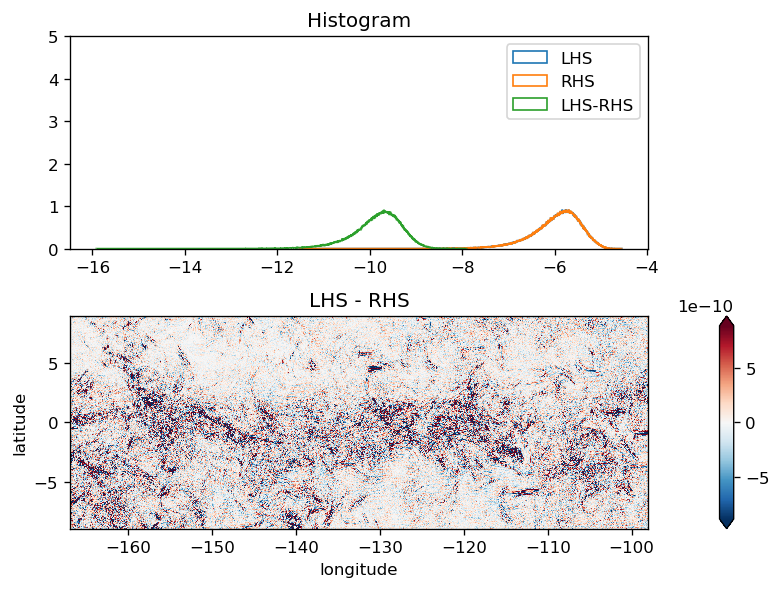

In [ ]:
level = 120
levelp = level + 1

terms = budget.isel(depth=level).squeeze()

metrics_sub = metrics.isel(depth=level, latitude=slice(1, -1), longitude=slice(1, -1))
cellvol = metrics_sub.cellvol.transpose()

terms["ADVr_THp"] = budget["ADVr_TH"].isel(depth=levelp).squeeze()
terms["DFrI_THp"] = budget["DFrI_TH"].isel(depth=levelp).squeeze()
terms["KPPg_THp"] = budget["KPPg_TH"].isel(depth=levelp).squeeze()

surf_mass = terms.WTHMASS[1:-1, 1:-1] * metrics_sub.RAC[1:-1, 1:-1]

# constants taken from diagnostics.log (I think)
global_area = 2.196468634481708e13
rhoConst = 1035
Cp = 3994
TsurfCor = surf_mass.sum() / global_area

LHS = terms.TOTTTEND[1:-1, 1:-1] / 86400

ADVx = (terms.ADVx_TH.values[2:, 1:-1] - terms.ADVx_TH.values[1:-1, 1:-1]) / cellvol
ADVy = (terms.ADVy_TH.values[1:-1, 2:] - terms.ADVy_TH.values[1:-1, 1:-1]) / cellvol
ADVr = (
    terms.ADVr_TH.fillna(0).values[1:-1, 1:-1] - terms.ADVr_THp.values[1:-1, 1:-1]
) / cellvol

# no explicit diffusion
# DFxE = (terms.DFxE_TH.values[2:, 1:-1] - terms.DFxE_TH.values[1:-1, 1:-1]) / cellvol
# DFyE = (terms.DFyE_TH.values[1:-1, 2:] - terms.DFyE_TH.values[1:-1, 1:-1]) / cellvol
# DFrE = (terms.DFrE_TH.values[1:-1, 1:-1] - terms.DFrE_THp.values[1:-1, 1:-1]) / cellvol
DFrI = (
    terms.DFrI_TH.fillna(0).values[1:-1, 1:-1] - terms.DFrI_THp.values[1:-1, 1:-1]
) / cellvol

# non-local stuff only in mixing layer
KPPg = (
    terms.KPPg_TH.fillna(0).values[1:-1, 1:-1]
    - terms.KPPg_THp.fillna(0).values[1:-1, 1:-1]
) / cellvol

ADV = LHS.copy(data=ADVx + ADVy + ADVr)
DIFF = LHS.copy(data=DFrI + KPPg)  # no explicit horizontal diffusion
ADV.name = "ADV"
DIFF.name = "DIFF"

SW = (
    terms.oceQsw[1:-1, 1:-1]
    / (rhoConst * Cp)
    / (metrics_sub.dRF * metrics_sub.hFacC)
    * terms.swprofile
)

RHS = ADV + DIFF + SW

# surface level stuff
if level == 0:
    # surface tendency due to SW flux
    tflx_tend = (terms.TFLUX[1:-1, 1:-1] - terms.oceQsw[1:-1, 1:-1]) / (
        rhoConst * Cp * metrics_sub.dRF * metrics_sub.hFacC
    )

    # tendency due to mass correction
    surf_corr_tend = -(
        (terms.WTHMASS[1:-1, 1:-1] - TsurfCor) / (metrics_sub.dRF * metrics_sub.hFacC)
    )

    RHS += tflx_tend + surf_corr_tend

RHS *= -1

plot_lhs_rhs(LHS, RHS)